In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_real_power = pd.read_csv('../debug_logs/real_power.csv', index_col=0)
df_scen = pd.read_csv("../debug_logs/scenarios.csv")
df_quant = pd.read_csv("../debug_logs/quant_next_step.csv")



In [3]:
def quant_from_power(real_power, row, columns):
    for i, quant_bnd in enumerate(columns[2:]):
        quant_val = row[quant_bnd]
        quant_bnd = float(quant_bnd)
        if real_power < quant_val:
            if i == 0:
                bnd_res = quant_bnd
            else:
                bnd_inter = quant_bnd-prev_bnd
                val_inter = quant_val-prev_val
                pow_inter = real_power-prev_val
                bnd_res = prev_bnd+pow_inter/val_inter*bnd_inter
            break
        prev_val = quant_val
        prev_bnd = quant_bnd
        bnd_res = quant_bnd
    return bnd_res


In [4]:
def quant_counter(real_power, row, columns):
    for i, quant_bnd in enumerate(columns[2:]):
        quant_val = row[quant_bnd]
        quant_bnd = float(quant_bnd)

In [5]:
def plot_both_cumul(quantiles_bnd, quantile_proportion, labels):
    fig = plt.figure()
    ax = fig.add_subplot()

    plt.plot([0,1],[0,1])
    for i, val in enumerate(quantiles_bnd):
        plt.scatter(val, quantile_proportion[i], label=labels[i])
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel("Quantiles")
    plt.ylabel("Proportion of points below this quantile")
    plt.legend()


In [6]:
def get_plot_from_files(real_power, scenarios, quant_next_step):
    df_real_power = pd.read_csv(real_power, index_col=0)
    df_scen = pd.read_csv(scenarios)
    df_quant = pd.read_csv(quant_next_step)

    real_below_counter = [0 for _ in df_quant.columns[2:]]
    real_tot = 0

    sample_below_counter = [0 for _ in df_quant.columns[2:]]
    sample_tot = 0


    for _, row in df_quant.iterrows():
        build_num = int(row["building"])
        time_step = int(row["time_step"])
        if time_step == df_real_power.shape[0]-1:
            break
        real_power = df_real_power[f"building_{build_num}"][time_step]
        
        for i, quant_bnd in enumerate(df_quant.columns[2:]):
            quant_val =row[quant_bnd]
            if real_power<quant_val:
                real_below_counter[i] += 1
        real_tot += 1

        same_building = df_scen['time_step'] == time_step
        same_time_step = df_scen['building'] == build_num
        sep_df = list(df_scen.loc[same_building & same_time_step, '+1h'])
        for pow in sep_df:
            pow = float(pow)
            
            for i, quant_bnd in enumerate(df_quant.columns[2:]):
                quant_val =row[quant_bnd]
                if pow<quant_val:
                    sample_below_counter[i] += 1
            sample_tot += 1
    
    quantiles = df_quant.columns[2:]
    quant_float = [float(i)for i in quantiles]

    real_below_norm = [i/real_tot for i in real_below_counter]

    sample_below_norm = [i/sample_tot for i in sample_below_counter]
    
    plot_both_cumul([quant_float]*2,[real_below_norm, sample_below_norm], ["Real powers", "Sample powers"])
    return quant_float,real_below_norm


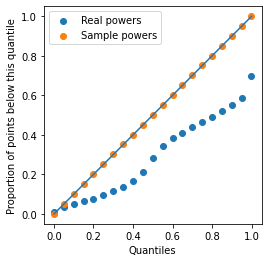

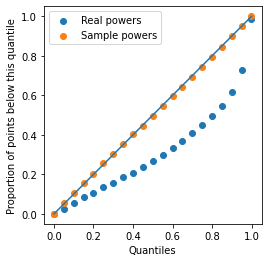

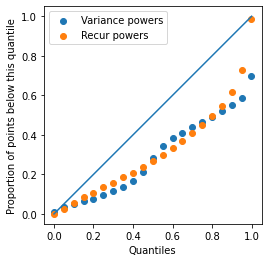

In [7]:
file_end = "_point_and_variance_9000.csv"
real_power_path = f"../debug_logs/real_power{file_end}"
scenarios_path = f"../debug_logs/scenarios{file_end}"
quant_next_step_path = f"../debug_logs/quant_next_step{file_end}"

quant_var, prop_real_var = get_plot_from_files(real_power_path, scenarios_path, quant_next_step_path)

file_end = ".csv"
real_power_path = f"../debug_logs/real_power{file_end}"
scenarios_path = f"../debug_logs/scenarios{file_end}"
quant_next_step_path = f"../debug_logs/quant_next_step{file_end}"

quant_recur, prop_real_recur = get_plot_from_files(real_power_path, scenarios_path, quant_next_step_path)

plot_both_cumul([quant_var,quant_recur],[prop_real_var, prop_real_recur], ["Variance powers", "Recur powers"])


In [54]:
# Check if the quantile forecasting is good

real_bnd_counter = list()
sample_bnd_counter = list()

real_below_counter = [0 for _ in df_quant.columns[2:]]
real_tot = 0

sample_below_counter = [0 for _ in df_quant.columns[2:]]
sample_tot = 0


for _, row in df_quant.iterrows():
    build_num = int(row["building"])
    time_step = int(row["time_step"])
    if time_step == df_real_power.shape[0]-1:
        break
    real_power = df_real_power[f"building_{build_num}"][time_step]
    
    real_bnd = quant_from_power(real_power, row, df_quant.columns)
    real_bnd_counter.append(real_bnd)

    for i, quant_bnd in enumerate(df_quant.columns[2:]):
        quant_val =row[quant_bnd]
        if real_power<quant_val:
            real_below_counter[i] += 1
    real_tot += 1

    same_building = df_scen['time_step'] == time_step
    same_time_step = df_scen['building'] == build_num
    sep_df = list(df_scen.loc[same_building & same_time_step, '+1h'])
    for pow in sep_df:
        pow = float(pow)
        sample_bnd = quant_from_power(pow, row, df_quant.columns)
        sample_bnd_counter.append(sample_bnd)

        for i, quant_bnd in enumerate(df_quant.columns[2:]):
            quant_val =row[quant_bnd]
            if pow<quant_val:
                sample_below_counter[i] += 1
        sample_tot += 1


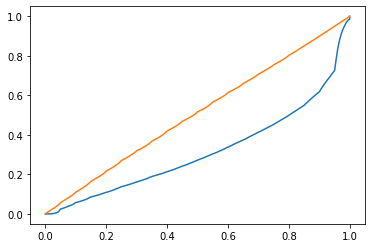

In [55]:
cumulative = np.sort(real_bnd_counter)
y = [i/len(cumulative) for i, _ in enumerate(cumulative)]
# plot the cumulative function
plt.plot(cumulative, y)

cumulative = np.sort(sample_bnd_counter)
y = [i/len(cumulative) for i, _ in enumerate(cumulative)]
# plot the cumulative function
plt.plot(cumulative, y)

plt.show()

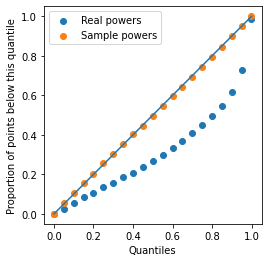

In [56]:
quantiles = df_quant.columns[2:]
quant_float = [float(i)for i in quantiles]

real_below_norm = [i/real_tot for i in real_below_counter]

sample_below_norm = [i/sample_tot for i in sample_below_counter]
fig = plt.figure()
ax = fig.add_subplot()

plt.plot([0,1],[0,1])
plt.scatter(quant_float, real_below_norm, label="Real powers")
plt.scatter(quant_float, sample_below_norm, label = "Sample powers")
ax.set_aspect('equal', adjustable='box')
plt.xlabel("Quantiles")
plt.ylabel("Proportion of points below this quantile")
plt.legend()
